In [86]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import pickle

In [4]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

# Euler's Method

In [5]:
dt = 0.01
T = 100
t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))
U = np.zeros((len(t),1))

Q = np.zeros((4,4))
Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01
r_m = 0.1

In [6]:
C[:,:,0] = 0
U[0] = 0.001

for i in range(0,len(t)-1):

                A = W + U[i]*L

                R = C[0,2,i]*(0.25 * k * ((k_plus**2) - (k_e**2)))

                C[:,:,i+1] = C[:,:,i]+ dt*(A @ C[:,:,i]  + C[:,:,i] @ A.T + epsilon*Q)

                U[i+1] = U[i] + dt*(-r_m*U[i]+R)
                
mean_U = np.mean(U)

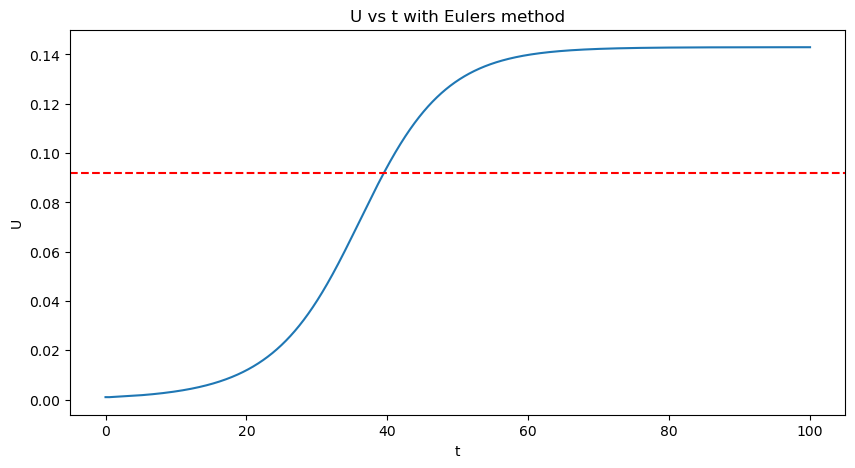

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(t, U)
plt.axhline(mean_U, linestyle='--', color='r')
plt.xlabel('t')
plt.ylabel('U')
plt.title('U vs t with Eulers method')
plt.show()

# Runge Kutta Fourth Order Method

In [8]:
dt = 0.01

T = 200

t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))

U = np.zeros((len(t),1))

Q = np.zeros((4,4))

Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01

r_m = 0.1

In [9]:
def rhs(t, U_and_C, r_m, W, L, epsilon, Q):
    U = U_and_C[0]
    C = U_and_C[1:].reshape(4, 4)
    A = W + U * L
    R = C[0, 2] * (0.25 * k * ((k_plus**2) - (k_e**2)))
    dCdt = A @ C + C @ A.T + epsilon * Q
    return np.array([-r_m * U + R, *dCdt.flatten()])

def rk4_method(rhs, y0, t_span, dt, *args):
    
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        k1 = rhs(t[i-1], y[:, i-1], *args)
        k2 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k1, *args)
        k3 = rhs(t[i-1] + dt/2, y[:, i-1] + dt/2 * k2, *args)
        k4 = rhs(t[i-1] + dt, y[:, i-1] + dt * k3, *args)

        y[:, i] = y[:, i-1] + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return t, y

U0 = 0.001
C0 = np.zeros((4, 4))
initial = np.array([U0, *C0.flatten()])

# Solve the ODE system using rk4_method
t_rk4, sol_rk4 = rk4_method(rhs, initial, (0, T), dt, r_m, W, L, epsilon, Q)


U_rk4 = sol_rk4[0, :]
C_rk4 = sol_rk4[1:].reshape(-1, 4, 4)
mean_U_rk4 = np.mean(U_rk4)

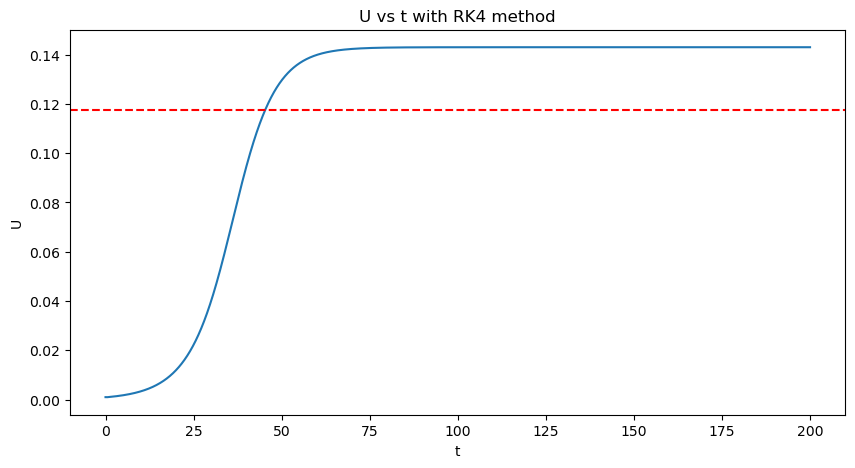

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(t_rk4, U_rk4)
plt.axhline(mean_U_rk4, linestyle='--', color='r') 
plt.xlabel('t')
plt.ylabel('U')
plt.title('U vs t with RK4 method')
plt.show()

# Solving R(U) and plotting the R_space against the U_space

## Using the Euler's method for that-

In [30]:
dt = 0.01
T = 10
t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))

Q = np.zeros((4,4))
Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01
r_m = 0.1

U_space  = np.linspace(-0.05,0.05,20)
#U_space = np.array([-0.05,0, 0.05])
R_space = np.zeros(U_space.shape)

for i in range(0,len(U_space)):

    A = W + U_space[i]*L

    for j in range(0,len(t)-1):

        C[:,:,j+1] = C[:,:,j]+ dt*(A @ C[:,:,j]  + C[:,:,j] @ A.T + epsilon * Q)

    R_space[i] = C[0,2,-1]*(0.25 * k * ((k_plus ** 2) - (k_e ** 2)))  ##Change C[0,2,-1] to see a different result

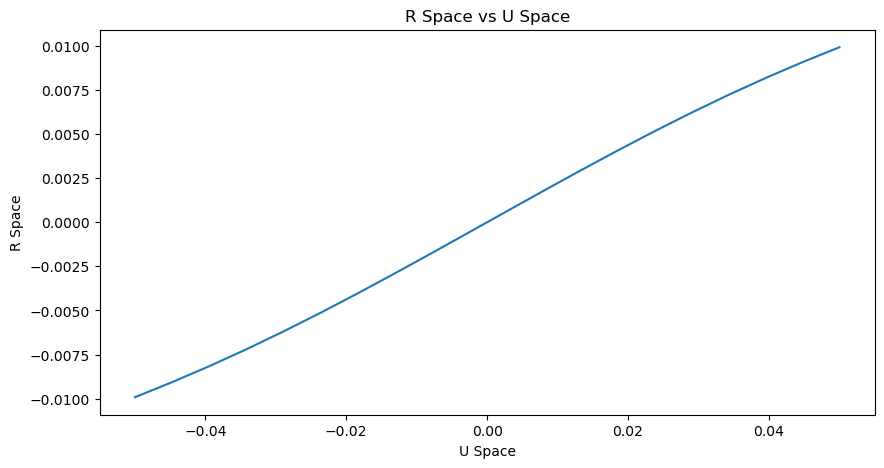

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(U_space, R_space, '-')
plt.xlabel('U Space')
plt.ylabel('R Space')
plt.title('R Space vs U Space')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(U_space, R_space)
plt.xlabel('U Space')
plt.ylabel('R Space')
plt.title('R Space vs U Space')
plt.show()

In [97]:
def rk4_step(A, C, dt, epsilon, Q):
    k1 = dt * (A @ C + C @ A.T + epsilon * Q)
    k2 = dt * (A @ (C + 0.5 * k1) + (C + 0.5 * k1) @ A.T + epsilon * Q)
    k3 = dt * (A @ (C + 0.5 * k2) + (C + 0.5 * k2) @ A.T + epsilon * Q)
    k4 = dt * (A @ (C + k3) + (C + k3) @ A.T + epsilon * Q)

    return C + (k1 + 2 * k2 + 2 * k3 + k4) / 6

dt = 0.01
T = 10
t = np.linspace(0, T, int(T/dt) + 1)

C = np.zeros((4, 4, len(t)))

Q = np.zeros((4, 4, len(t)))
Q[0, 0] = 8 / (k_e ** 2)

epsilon = 0.01
r_m = 0.1

U_space = np.linspace(-0.1, 0.15, 20)
R_space = np.zeros(U_space.shape)
eig_space = np.zeros(U_space.shape)

for i in range(0, len(U_space)):
    A = W + U_space[i] * L
    w, v = LA.eig(A)
    w_real = np.real(w)
    eig_space[i] = np.max(w_real)

    for j in range(0, len(t) - 1):
        C[:,:,j+1] = rk4_step(A, C[:,:,j], dt, epsilon, Q[:,:,j])

    R_space[i] = C[0, 2, -1] * (0.25 * k * ((k_plus ** 2) - (k_e ** 2)))

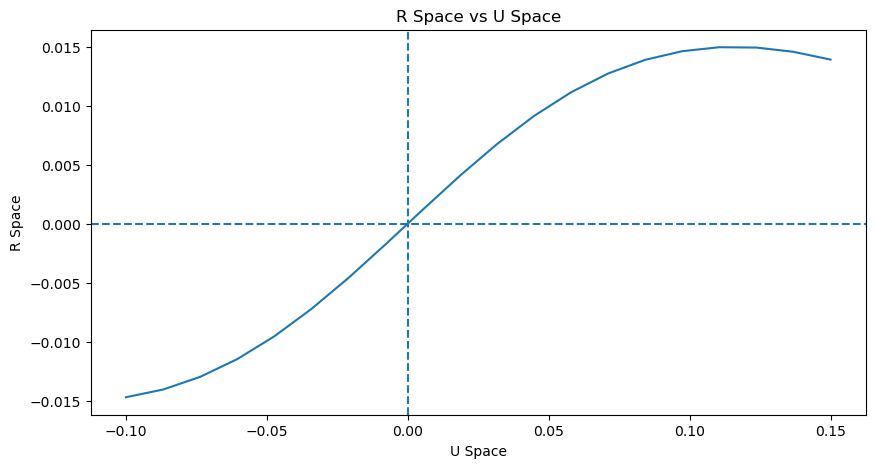

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(U_space, R_space)
plt.xlabel('U Space')
plt.ylabel('R Space')
plt.title('R Space vs U Space')
plt.axhline(0 , linestyle='--')
plt.axvline(0 , linestyle='--')
plt.show()

In [99]:
with open("variables.pickle", "wb") as f:
    pickle.dump((R_space, U_space), f)

## Using the RK4 method for that-

In [25]:
def rhs(U_C, t, W, L, epsilon, Q):
    U = U_C[0]
    C = U_C[1:].reshape(4, 4)
    A = W + U * L
    R = C[0, 2] * (0.25 * k * ((k_plus ** 2) - (k_e ** 2)))
    dCdt = A @ C + C @ A.T + epsilon * Q
    return np.array([R -r_m * U, *dCdt.flatten()])

def rk4_method(rhs, y0, t_span, dt, *args):
    
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    y = np.zeros((len(y0), len(t)))
    y[:, 0] = y0

    for i in range(1, len(t)):
        k1 = rhs(y[:, i-1], t[i-1], *args)
        k2 = rhs(y[:, i-1] + dt/2 * k1, t[i-1] + dt/2, *args)
        k3 = rhs(y[:, i-1] + dt/2 * k2, t[i-1] + dt/2, *args)
        k4 = rhs(y[:, i-1] + dt * k3, t[i-1] + dt, *args)

        y[:, i] = y[:, i-1] + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return t, y

dt = 0.01
T = 100
t = np.linspace(0,T,int(T/dt)+1)

Q = np.zeros((4,4))
Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01
r_m = 0.1
U_space_rk4  = np.linspace(-0.5,0.5,10)
#U_space_rk4 = np.linspace(0.1,0.2,2)

R_space_rk4 = np.zeros(U_space_rk4.shape)

for i in range(0, len(U_space_rk4)):
    U0 = U_space_rk4[i]
    C = np.zeros((4, 4))
    UandC = np.concatenate(([U0], C.flatten()))

    t, UC_sol = rk4_method(rhs, UandC, (0, T), dt, W, L, epsilon, Q)

    C_rk4 = UC_sol[1:, -1].reshape(4, 4)

    R_space_rk4[i] = C_rk4[0, 2] * (0.25 * k * ((k_plus ** 2) - (k_e ** 2)))

In [26]:
U_space_rk4

array([0.1, 0.2])

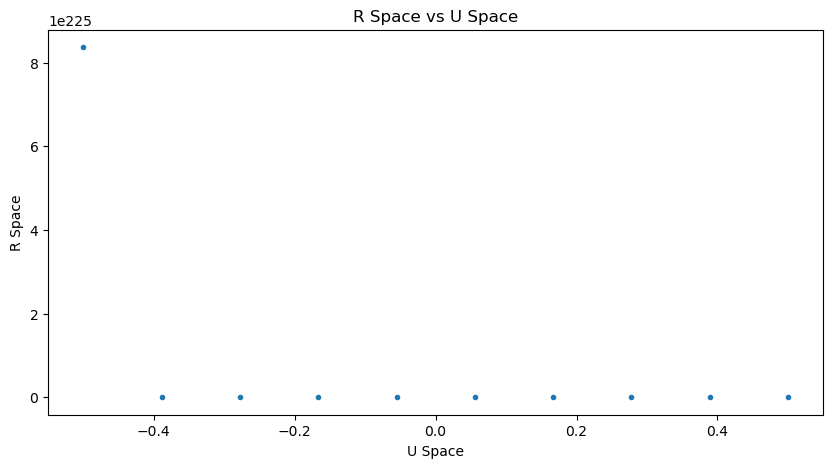

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(U_space_rk4, R_space_rk4, '.')
plt.xlabel('U Space')
plt.ylabel('R Space')
plt.title('R Space vs U Space')
#plt.xlim(-0.05,0.05)
plt.show()